In [1]:
import cv2
import glob
import numpy as np
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm
from os import listdir
import multiprocessing
workers = multiprocessing.cpu_count()//2 # number of cpu cores available
from keras.preprocessing import image
from keras.utils import Sequence, plot_model
from keras import backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, Conv2DTranspose
from keras.layers import Activation, BatchNormalization, Dropout, Reshape, Lambda
from keras.optimizers import Adadelta, Nadam
from keras.models import Model, load_model
from keras.losses import binary_crossentropy

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

Future Vision Transport is a company that designs onboard computer vision systems for autonomous vehicles. 
The different components of the computer vision system:
1. Real-time image acquisition
2. Image processing
3. Image segmentation and
4. Decision-making system
Data for this project can be found at https://www.cityscapes-dataset.com/examples/#fine-annotations

some examples on the data
* https://github.com/srihari-humbarwadi/cityscapes-segmentation-with-Unet/blob/master/batch_training.py (old repo)
* https://github.com/srihari-humbarwadi/DeepLabV3_Plus-Tensorflow2.0/blob/master/inference.ipynb (new repo)
* https://github.com/NVIDIA/semantic-segmentation/blob/main/datasets/cityscapes.py

dilatednet 

https://medium.com/towards-data-science/review-dilated-convolution-semantic-segmentation-9d5a5bd768f5

sematic segmentation

https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html

Data generator example

https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

FastRCNN-VGG16

https://github.com/trzy/FasterRCNN/blob/master/tf2/FasterRCNN/models/vgg16.py

#### Deeplab Model


https://github.com/VainF/DeepLabV3Plus-Pytorch/blob/master/README.md

<h2><b> Image Segmentation:</b></h2>
Image segmentation is a computer vision task that involves partitioning an image into multiple segments or regions, each representing a different object or part of the image. The goal of image segmentation is to simplify the representation of an image and make it more meaningful and easier to analyze. By segmenting an image, we can identify and isolate specific objects or regions of interest, which can be useful for various applications such as object detection, image recognition, and scene understanding.

Image segmentation is the task of classifying/assigning each pixel in an image to a class. It is a computer vision technique that seperates different objects/items in an image for better or meaningful analysis. The input in this process is an image and the output is a mask that defines/draws the region of the shape/object in the image. Image segmentation has wide applications in domains such as medical image analysis, autonomous cars, satellite image analysis, etc. There are different types of image segmentation techniques like semantic segmentation, instance segmentation, etc.

The basic concept of image segmentation invovles the following steps:
*   Group pixels in an image based on some shared charateristics i.e. color, texture etc
*   Assign each pixel a label indicating what class/object it belongs to.
*   A mask segmenting the different objects/segments in the image.

Image segmentation breaks down complex images into manageable pieces by precisely isolating objects (things) and backgrounds (stuff) within the image making image analysis more efficient and accurate. This is essential for facilitating computer vision tasks like feature extraction, pattern recognition, autonomous-driving cars identifying objects, and medical imaging analysis for tumours.

Image segmentation is a crucial step in computer vision and image analysis, as it allows for more detailed and accurate understanding of the visual data.

Two approaches to image segmentation are similarity approach and discontinuity approach. 
* Similarity approach groups pixels based on their similarity in color, texture, or other features and assumes regions with similar charatersotics should be grouped together. 
* Discontinuity approach divides an image into regions based on predefined criteria, such as intensity or color and focuses on detecting abrupt changes in intensity or region boundaries.

The similarity approach is based on the idea that pixels in an image that are similar in color, texture, or other features should be grouped together. This approach is often used for segmenting homogeneous regions in an image for tasks such as object recognition and image classification, and can be applied to images with smooth transitions and gradual changes in intensity. The discontinuity approach, on the other hand, focuses on detecting abrupt changes in intensity or color in an image. This approach is often used for tasks such as edge and boundary detection for segmenting images with sharp edges or boundaries. It can be applied to images with high contrast and distinct regions.

The two approaches can be used together to achieve more accurate segmentation results.

Examples of Similarity approach are region growing, clustering (e.g., K-Means, Mean-Shift), thresholding, and graph-based segmentation (e.g., Normalized Cuts, Min-Cut/Max-Flow), while examples of discontinuity approach are edge detection (e.g., Sobel Operator, Canny Edge Detector), Corner Detection (e.g., Harris Corner Detector), and Line Detection (e.g., Hough Transform).

<b>Semantic segmentation</b>

Semantic Segmentation is one of the different types of image segmentation where a class label is assigned to image pixels using deep learning (DL) algorithm. In Semantic Segmentation, collections of pixels in an image are identified and classified by assigning a class label based on their characteristics such as colour, texture and shape. This provides a pixel-wise map of an image (segmentation map) to enable more detailed and accurate image analysis. Here all pixels that represent an object (eg human, car, tree, ect) are labeled with the object name without specifiying individual members of the group.

<b>Instance segmentation</b>

Instance segmentation in image segmentation of computer vision task is a more sophisticated feature which involves identifying and delineating each individual object within an image. So instance segmentation goes beyond just identifying objects in an image, but also delineate the exact boundaries of each individual instance of that object.

So, the key focus of instance segmentation is to differentiate between separate objects of the same class. for example, if there are many cats in a image, instance segmentation would identify and outline each specific cat. The segmentation map is created for each individual pixel and separate labels are assigned to specific object instances by creating different colored labels which will represent different 'cat' in the group of cats in an image.

<b>Panoptic segmentation</b>

Panoptic segmentation combines the features and processes of semantic and instance segmentation techniques as a consequence panoptic segmentation algorithm creates a comprehensive image analysis by simultaneously classifying every pixel and identifying distinct object instances of the same class. For example, an image with multiple cars and pedestrians at a traffic signal, a panoptic segmentation would label all 'pedestrians' and 'cars' (semantic segmentation) and draw bounding boxes around them to identify and segment each individual persons and cars and also classifying the different surrounding scenarios like road signals, traffic lights and all other building or backgrounds. So panoptic segmentation detects and interprets everything within a given image.

Panoptic segmentation leverages the strengths of fully convolutional networks (FCN) for semantic context and Mask R-CNN for instance-specific details, which gives a combined output for achieving a more holistic and nuanced understanding of visual data.

Semantic image segmentation is the task of classifying each pixel in an image to predetermined set of classes.

Example of original image and its mask:

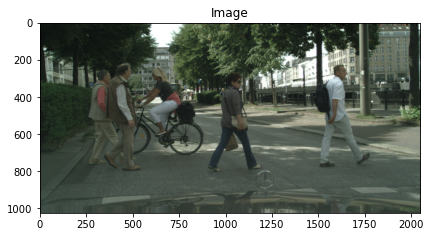  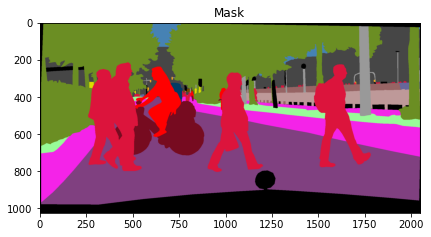

In the above example pixels belonging to human are classified to the class human, those beloning to car are classified to car and so on.
In segmentation we take an image of size (width x height x 3) and convert it to a matrix of size (width x height) containing predicted class ids corresponding to the pixels of the image.

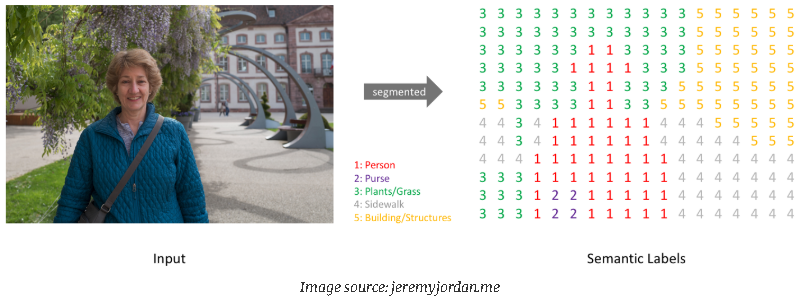 

source: https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html

To summarize the key goal of image segmentation is to recognize and understand what’s in an image at the pixel level.

<h2><b>Traditional Image Segmentation Techniques</b></h2>
Traditional image segmentation techniques such as thresholding, edge detection, Region-Based Segmentation, clustering algorithms and Watershed Segmentation formed the foundation of modern image segmentation methods using deep learning algorithms.

*   *Thresholding*: 

involves selecting a threshold value and classifying image pixels between foreground and background based on intensity values. Thresholding is a simple and effective technique for segmenting images with distinct intensity differences between objects and background. It involves converting a grayscale image into a binary image by applying a threshold value. Pixels with intensity values above the threshold are classified into one category, while those below the threshold are classified into another. It is often used in applications such as document image analysis, medical imaging, and industrial inspection.

    *   *Global Thresholding*: 
        uses a single threshold value for the entire image to separate foreground and background pixels. It is effective for images with uniform lighting and contrast, example in a document image, it can effectively separate the text from the white background.

    *   *Adaptive Thresholding*:
        calculates different threshold values for different regions of the image based on local pixel intensity variations.

    *   *Otsu's Method*:
        automatically determines the optimal threshold value by maximizing the variance between the foreground and background pixel intensities.

*   *Edge Detection*:

identify abrupt change in intensity or discontinuation in the image, uses algorithms like Sobel, Canny or Laplacian edge detectors.

    * *Sobel Operator*:
        a simple and effective gradient-based edge detection technique that uses convolution with Sobel kernels to approximate the gradient of the image intensity. It highlights regions with high spatial frequency, effectively detecting edges. The Sobel operator is particularly useful for detecting horizontal and vertical edges.

    *   *Prewitt Operator*:        
        similar to the Sobel operator, but uses different convolution kernels to approximate the gradient. It is effective for detecting edges in various orientations and is often used in image processing applications.

    *   *Scharr Operator*:
        an improved version of the Sobel operator that provides better edge detection results by using a different convolution kernel. It is particularly effective for detecting edges in images with high-frequency content and is often used in applications such as image enhancement and feature extraction.

    *   *Roberts Cross Operator*:        
        a simple edge detection technique that uses convolution with Roberts kernels to approximate the gradient of the image intensity. It is effective for detecting edges in images with high-frequency content and is often used in applications such as image enhancement and feature extraction.

    *   *Laplacian or Gaussian (LoG) Operator*:        
        a second-order derivative operator that detects edges by identifying regions of rapid intensity change. The method combines Gaussian smoothing with the Laplacian operator to detect edges and involves smoothing the image to reduce noise and then applying the Laplacian operator to highlight regions of rapid intensity change.It is effective for detecting edges in images with high-frequency content and is often used in applications such as image enhancement and feature extraction.

    *   *Canny Edge Detector*:        
        a multi-stage algorithm that includes noise reduction, gradient calculation, non-maximum suppression, and edge tracking by hysteresis. It is known for its ability to detect a wide range of edges while minimizing false positives. The Canny edge detector is widely used in applications requiring precise edge detection, such as object recognition and medical imaging.

*   *Region-based segmentation*:

segments the image into smaller regions and iteratively merges them based on predefined attributes in color, intensity and texture to handle noise and irregularities in the image. The approach assumes that pixels within the same region have similar characteristics.

    *   *Region Growing*:        
        starts with seed points and iteratively adds neighboring pixels to the region based on similarity criteria. It continues until no more pixels can be added. It is simple and intuitive, producing connected regions, but it is also sensitive to noise and requires careful selection of seed points. It is effective for segmenting homogeneous regions in an image and is often used in applications such as medical imaging and object recognition.

    *   *Region Splitting and Merging*:        
        is a hierarchical method that involves dividing the image into smaller regions and merging adjucent regions based on similarity criteria. We start with entire image as a single region, and the region is then recursively split until the resulting regions are homogeneous. It is effective for segmenting complex images with varying textures and is often used in applications such as image compression and feature extraction.

    *   *Morphological (Watershed) Segmentation*:    
        uses morphological operations like dilation, erosion, opening, and closing to extract features from the image. It treats the image as a topographic surface, where pixel values represent the elevation and identifies the catchment basins and ridge lines, segmenting the image into distinct regions. It is particularly useful for separating overlapping objects in an image, making it effective for segmenting images with complex shapes and is often used in applications such as object detection and medical imaging.

*   *Graph-based Segmentation*: 

represents the image as a graph and uses graph-cut algorithms to partition the image into segments based on pixel connectivity and similarity. It is effective for segmenting images with complex structures and is often used in applications such as object recognition and image segmentation.

    *   *Normalized Cuts*:    
        a graph-based segmentation technique that partitions the image into segments by minimizing the normalized cut cost function. It is effective for segmenting images with complex structures and is often used in applications such as object recognition and image segmentation.

    *   *Min-Cut/Max-Flow*: 
        a graph-based segmentation technique that partitions the image into segments by minimizing the cut cost function. It is effective for segmenting images with complex structures and is often used in applications such as object recognition and image segmentation.

*   *Clustering Algorithm*: 

uses algorithms like K-means or Gaussian models to group object pixels in an image into clusters based on similar features like color or texture.

    *   *K-Means Clustering*:    
        a popular unsupervised learning algorithm that partitions the image into K clusters based on pixel intensity values. It iteratively assigns pixels to the nearest cluster centroid and updates the centroids until convergence. K-means clustering is effective for segmenting images with distinct color regions and is often used in applications such as image compression and object recognition.

    *   *Mean-Shift Clustering*:    
        a non-parametric clustering algorithm that iteratively shifts data points towards the mean of their local neighborhood. It is effective for segmenting images with varying densities and is often used in applications such as object tracking and image segmentation.

    *   *Gaussian Mixture Models (GMM)*:    
        a probabilistic model that represents the image as a mixture of multiple Gaussian distributions. 

    * *Fuzzy C-means Clustering*:    
        a soft clustering algorithm extending the K-Means algorithm that allows each pixel to belong to multiple clusters with varying degrees of membership. This approach is beneficial in handling images with ambiguous or overlapping regions, providing a more robust segmentation result. Fuzzy C-means clustering is commonly used in medical imaging and remote sensing.

<h2><b>Deep Learning Algorithms for Image Segmentation</b></h2>
Deep Learning algorithms have revolutionized image segmentation by providing more accurate and efficient methods for segmenting images. These algorithms leverage large datasets and powerful neural networks to learn complex patterns and features in images, enabling them to perform well on a wide range of segmentation tasks. Deep learning-based image segmentation techniques have shown significant improvements over traditional methods, making them the preferred choice for many applications.
There are various Deep Learning algorithms used in image segmentation. Some commonly used ones are:

**Convolutional Neural Networks (CNN):**
Convolutional Neural Networks (CNNs) are a specialized type of deep learning model designed to process and analyze visual data, they use three dimensional data for image processing. They have three node layers: an input layer, one or more hidden layers, and an output layer. Each node connects to another and has an associated weight and threshold. They are particularly effective for tasks such as image classification, object detection, and video analysis.

The architecture of CNN model contains several convolutional layers, non-linear activations, batch normalization, and pooling layers. The initial layers learn the low-level concepts such as edges and colors and the later level layers learn the higher level concepts such as different objects.

At a lower level, the neurons contain information for a small region of the image, whereas at a higher level the neurons contain information for a large region of the image. Thus, as more layers are added, the size of the image keeps on decreasing and the number of channels keeps on increasing. The downsampling is done by the pooling layers. In image classification, spatial tensor is mapped from the convolution layers to a fixed length vector using the fully connected layers, which in turn destroys all the spatial information.

Spatial information is needed in semantic segementation and hence no fully connected layers are used. These are known as ***fully convolutional networks***. The convolutional layers coupled with downsampling layers produce a low-resolution tensor containing the high-level information.

Taking the low-resolution spatial tensor, which contains high-level information, we have to produce high-resolution segmentation outputs. To do that we add more convolution layers coupled with upsampling layers which increase the size of the spatial tensor. As we increase the resolution, we decrease the number of channels as we are getting back to the low-level information.

This is called an encoder-decoder structure. Where the layers which downsample the input are the part of the encoder and the layers which upsample are part of the decoder.

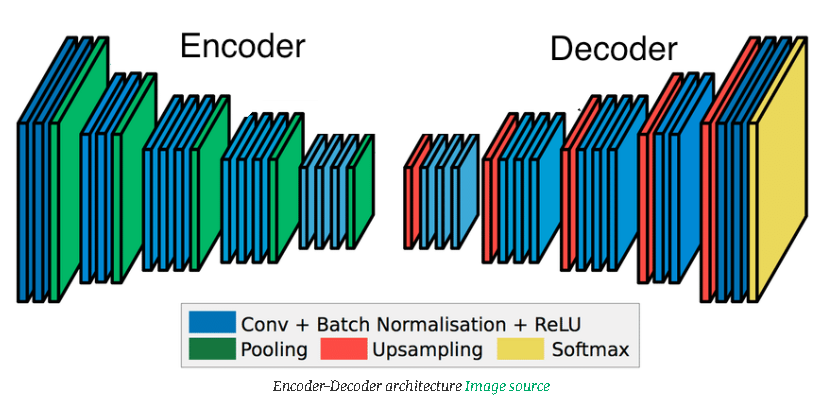

Source: https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html

Some of the popular CNN models used today are:
1.  Fully Convolutional Network (FCN):

This model has the ability to process image of any size and output spatial maps. This is achieved by replacing fully connected layers in a conventional CNN with convolutional layers. This helps in segmenting an entire image pixel by pixel.

2.  ResNet: 

This is the model proposed by Microsoft which got 96.4% accuracy in the ImageNet 2016 competition. ResNet is used as a pre-trained model for several applications. ResNet has large number of layers along with residual connections which make it’s training feasible.

3.  VGG-16: 

This is the model proposed by Oxford which got 92.7% accuracy in the ImageNet 2013 competition. Compared to Resnet it has lesser layers, hence it is much faster to train. For most of the existing segmentation benchmarks, VGG does not perform as good as ResNet in terms of accuracy. Before ResNet, VGG was the standard pre-trained model in for a large number of applications.

4.  SegNet: 

This model includes a encoder-decoder network, used for tasks like scene understanding and object recognition. The encoder here captures the context in the image and the decoder performs the precise localization and segmentation objects by using the context. The encoder and decoder layers are symmetrical to each other. The upsampling operation of the decoder layers use the max-pooling indices of the corresponding encoder layers.

5. UNet : 

The UNet architecture adopts an encoder-decoder framework with skip connections. Like SegNet, the encoder and decoder layers are symmetrical to each other. This model is very efficient in working with small amount of data and provide precise segmentation commonly used to efficiently segment medical images.

6. Mask R-CNN: 

This model extents the Faster R-CNN object detection framework, by adding a branch for predicting segmentation masks alongside bounding box regression.

7.  PSPNet : 

The Pyramid Scene Parsing Network is optimized to learn better global context representation of a scene. First, the image is passed to the base network to get a feature map. The the feature map is downsampled to different scales. Convolution is applied to the pooled feature maps. After that, all the feature maps are upsampled to a common scale and concatenated together. Finally a another convolution layer is used to produce the final segmentation outputs. Here, the smaller objects are captured well by the features pooled to a high resolution, whereas the large objects are captured by the features pooled to a smaller size.

8.  Vision Transformer (ViT): 

A new model that applies transformers to image segmentation. The image is divided into patches and processes them sequentially to understand the global context of the image.

from:

https://www.geeksforgeeks.org/explain-image-segmentation-techniques-and-applications/ 

https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html

https://www.geeksforgeeks.org/image-segmentation-approaches-and-techniques-in-computer-vision/

<h2><b>Image Segmentation Ecalaution Metrics</b></h2>
The performance of image segmentation algorithms is evaluated using various metrics that measure the accuracy and quality of the segmentation results. Some commonly used evaluation metrics for image segmentation include:

1. **Pixel Accuracy**: 

   Measures the percentage of correctly classified pixels in the segmented image compared to the ground truth. It is calculated as the ratio of correctly predicted pixels to the total number of pixels in the image. Can be less informative for imbalanced datasets where some classes dominate the image.

   $$Pixel Acuracy = \frac{Number of Correctly Classified Pixels}{Total Number of Pixels}$$

    where Number of Correctly Classified Pixels is the sum of true positive and true negative pixels, and Total Number of Pixels is the total number of pixels in the image.
    
2. **Mean Pixel Accuracy**:

   Measures the average pixel accuracy across all classes. It is calculated as the mean of the pixel accuracies for each class. This metric provides a more balanced evaluation of the model's performance across different classes.
   $$Mean Pixel Accuracy = \frac{1}{C} \sum_{i=1}^{C} \frac{TP_i}{TP_i + FN_i}$$
    where C is the number of classes, TP_i is the number of true positive pixels for class i, and FN_i is the number of false negative pixels for class i.

3. **Mean Intersection over Union (IoU)**:

   Measures the overlap between the predicted segmentation and the ground truth. It is calculated as the ratio of the intersection of the predicted and ground truth regions to their union. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$Mean IoU = \frac{1}{C} \sum_{i=1}^{C} \frac{TP_i}{TP_i + FP_i + FN_i}$$
    where C is the number of classes, TP_i is the number of true positive pixels for class i, FP_i is the number of false positive pixels for class i, and FN_i is the number of false negative pixels for class i.

4. **Frequency Weighted IoU**:

   Measures the IoU for each class, weighted by the frequency of that class in the ground truth. This metric accounts for class imbalance and provides a more comprehensive evaluation of the model's performance.
   $$Frequency Weighted IoU = \frac{1}{N} \sum_{i=1}^{C} \frac{TP_i}{TP_i + FP_i + FN_i}$$
    where N is the total number of pixels in the ground truth, C is the number of classes, TP_i is the number of true positive pixels for class i, FP_i is the number of false positive pixels for class i, and FN_i is the number of false negative pixels for class i.

5. **F1 Score**:

   Measures the balance between precision and recall. It is calculated as the harmonic mean of precision and recall. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$F1 Score = \frac{2 \cdot Precision \cdot Recall}{Precision + Recall}$$
    where Precision = $\frac{TP}{TP + FP}$ and Recall = $\frac{TP}{TP + FN}$.

6. **Dice Coefficient**:

   Measures the similarity between the predicted segmentation and the ground truth. It is calculated as the ratio of twice the intersection of the predicted and ground truth regions to their sum. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$Dice Coefficient = \frac{2 \cdot TP}{2 \cdot TP + FP + FN}$$
    where TP is the number of true positive pixels, FP is the number of false positive pixels, and FN is the number of false negative pixels.
    
7. **Hausdorff Distance**:

   Measures the maximum distance between the predicted segmentation and the ground truth. It is calculated as the maximum distance between any point in the predicted segmentation and the closest point in the ground truth. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$Hausdorff Distance = \max_{p \in P} \min_{q \in Q} d(p, q)$$
    where P is the set of points in the predicted segmentation, Q is the set of points in the ground truth, and d(p, q) is the distance between points p and q.
8. **Boundary F1 Score**:
   Measures the accuracy of the predicted boundaries compared to the ground truth. It is calculated as the harmonic mean of precision and recall for the boundary pixels. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$Boundary F1 Score = \frac{2 \cdot Precision_{boundary} \cdot Recall_{boundary}}{Precision_{boundary} + Recall_{boundary}}$$
    where Precision_{boundary} = $\frac{TP_{boundary}}{TP_{boundary} + FP_{boundary}}$ and Recall_{boundary} = $\frac{TP_{boundary}}{TP_{boundary} + FN_{boundary}}$.
9. **Average Precision (AP)**:
   Measures the average precision of the model across different IoU thresholds. It is calculated as the area under the precision-recall curve. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$AP = \int_{0}^{1} P(r) dr$$
    where P(r) is the precision at recall r.
10. **Mean Average Precision (mAP)**:
    Measures the mean average precision across all classes. It is calculated as the mean of the average precision for each class. This metric provides a more balanced evaluation of the model's performance across different classes.
   $$mAP = \frac{1}{C} \sum_{i=1}^{C} AP_i$$
    where C is the number of classes and AP_i is the average precision for class i.
11. **Pixel-wise Accuracy**:
    Measures the percentage of correctly classified pixels in the segmented image compared to the ground truth. It is calculated as the ratio of correctly predicted pixels to the total number of pixels in the image. This metric provides a simple and intuitive evaluation of the model's performance.
   $$Pixel-wise Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$
    where TP is the number of true positive pixels, TN is the number of true negative pixels, FP is the number of false positive pixels, and FN is the number of false negative pixels.
12. **True Positive Rate (TPR)**:
    Measures the proportion of actual positive pixels that are correctly predicted as positive. It is calculated as the ratio of true positive pixels to the total number of actual positive pixels. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$TPR = \frac{TP}{TP + FN}$$
    where TP is the number of true positive pixels and FN is the number of false negative pixels.
13. **False Positive Rate (FPR)**:
    Measures the proportion of actual negative pixels that are incorrectly predicted as positive. It is calculated as the ratio of false positive pixels to the total number of actual negative pixels. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$FPR = \frac{FP}{FP + TN}$$
    where FP is the number of false positive pixels and TN is the number of true negative pixels.
14. **True Negative Rate (TNR)**:
    Measures the proportion of actual negative pixels that are correctly predicted as negative. It is calculated as the ratio of true negative pixels to the total number of actual negative pixels. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$TNR = \frac{TN}{TN + FP}$$
    where TN is the number of true negative pixels and FP is the number of false positive pixels.
15. **False Negative Rate (FNR)**:
    Measures the proportion of actual positive pixels that are incorrectly predicted as negative. It is calculated as the ratio of false negative pixels to the total number of actual positive pixels. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$FNR = \frac{FN}{TP + FN}$$
    where FN is the number of false negative pixels and TP is the number of true positive pixels.
16. **Jaccard Index**:
    Measures the similarity between the predicted segmentation and the ground truth. It is calculated as the ratio of the intersection of the predicted and ground truth regions to their union. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$Jaccard Index = \frac{TP}{TP + FP + FN}$$
    where TP is the number of true positive pixels, FP is the number of false positive pixels, and FN is the number of false negative pixels.
17. **Structural Similarity Index (SSIM)**:
    Measures the similarity between two images based on luminance, contrast, and structure. It is calculated as the product of three components: luminance, contrast, and structure. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$SSIM(x, y) = \frac{(2\mu_x\mu_y + C_1)(2\sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}$$
    where x and y are the two images being compared, $\mu_x$ and $\mu_y$ are the mean pixel values of x and y, $\sigma_x^2$ and $\sigma_y^2$ are the variances of x and y, $\sigma_{xy}$ is the covariance between x and y, and $C_1$ and $C_2$ are small constants to avoid division by zero.
18. **Peak Signal-to-Noise Ratio (PSNR)**:
    Measures the ratio between the maximum possible power of a signal and the power of corrupting noise. It is calculated as the logarithm of the ratio of the maximum pixel value to the mean squared error between the predicted segmentation and the ground truth. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$PSNR = 10 \cdot \log_{10}\left(\frac{MAX^2}{MSE}\right)$$
    where MAX is the maximum pixel value, MSE is the mean squared error between the predicted segmentation and the ground truth.
19. **Normalized Cross-Correlation (NCC)**:
    Measures the similarity between two images by normalizing the cross-correlation between them. It is calculated as the ratio of the cross-correlation to the product of the standard deviations of the two images. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$NCC(x, y) = \frac{\sum_{i=1}^{N} (x_i - \mu_x)(y_i - \mu_y)}{\sqrt{\sum_{i=1}^{N} (x_i - \mu_x)^2} \cdot \sqrt{\sum_{i=1}^{N} (y_i - \mu_y)^2}}$$
    where x and y are the two images being compared, $x_i$ and $y_i$ are the pixel values of x and y, $\mu_x$ and $\mu_y$ are the mean pixel values of x and y, and N is the total number of pixels in the images.
20. **Normalized Mutual Information (NMI)**:
    Measures the amount of information shared between two images. It is calculated as the ratio of the mutual information to the geometric mean of the entropies of the two images. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$NMI(x, y) = \frac{2 \cdot I(x, y)}{H(x) + H(y)}$$
    where x and y are the two images being compared, $I(x, y)$ is the mutual information between x and y, and $H(x)$ and $H(y)$ are the entropies of x and y.
21. **Adjusted Rand Index (ARI)**:
    Measures the similarity between two data clusterings by comparing the number of pairs of samples that are assigned to the same or different clusters. It is calculated as the difference between the observed and expected indices, normalized by the maximum possible index. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$ARI = \frac{(TP + TN) - E}{\max(TP + TN, E)}$$
    where TP is the number of true positive pairs, TN is the number of true negative pairs, and E is the expected index.
22. **Variation of Information (VI)**:
    Measures the amount of information lost or gained when moving from one clustering to another. It is calculated as the sum of the conditional entropies of the two clusterings. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$VI = H(x) + H(y) - 2 \cdot I(x, y)$$
    where x and y are the two clusterings being compared, $H(x)$ and $H(y)$ are the entropies of x and y, and $I(x, y)$ is the mutual information between x and y.
23. **Entropy**:
    Measures the amount of uncertainty or randomness in a probability distribution. It is calculated as the negative sum of the probabilities multiplied by their logarithm. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$Entropy(x) = -\sum_{i=1}^{N} p_i \cdot \log(p_i)$$
    where x is the probability distribution, $p_i$ is the probability of the i-th class, and N is the total number of classes.
24. **Kappa Coefficient**:
    Measures the agreement between two raters or classifiers. It is calculated as the ratio of the observed agreement to the expected agreement. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$Kappa = \frac{P_o - P_e}{1 - P_e}$$
    where $P_o$ is the observed agreement and $P_e$ is the expected agreement.
25. **Confusion Matrix**:
    A table that summarizes the performance of a classification model by comparing the predicted and actual labels. It provides a detailed breakdown of true positives, true negatives, false positives, and false negatives for each class. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$Confusion Matrix = \begin{bmatrix} TP & FP \\ FN & TN \end{bmatrix}$$
    where TP is the number of true positive pixels, TN is the number of true negative pixels, FP is the number of false positive pixels, and FN is the number of false negative pixels.
26. **Receiver Operating Characteristic (ROC) Curve**:
    A graphical representation of the performance of a binary classifier as the discrimination threshold is varied. It plots the true positive rate against the false positive rate at various threshold settings. The area under the ROC curve (AUC) provides a single measure of the model's performance across all thresholds. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$ROC = \frac{TP}{TP + FN}$$
    where TP is the number of true positive pixels and FN is the number of false negative pixels.
27. **Precision-Recall Curve**:
    A graphical representation of the performance of a binary classifier as the discrimination threshold is varied. It plots precision against recall at various threshold settings. The area under the precision-recall curve (AUC-PR) provides a single measure of the model's performance across all thresholds. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$Precision = \frac{TP}{TP + FP}$$
    where TP is the number of true positive pixels and FP is the number of false positive pixels.
    $$Recall = \frac{TP}{TP + FN}$$
     where TP is the number of true positive pixels and FN is the number of false negative pixels.
28. **Cohen's Kappa**:
    Measures the agreement between two raters or classifiers, taking into account the agreement that could occur by chance. It is calculated as the ratio of the observed agreement to the expected agreement. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$Cohen's Kappa = \frac{P_o - P_e}{1 - P_e}$$
    where $P_o$ is the observed agreement and $P_e$ is the expected agreement.
29. **Matthews Correlation Coefficient (MCC)**:
    Measures the correlation between the predicted and actual labels. It is calculated as the product of the true positive rate and true negative rate, normalized by the square root of the product of the false positive rate and false negative rate. This metric is particularly useful for evaluating models on imbalanced datasets.
   $$MCC = \frac{TP \cdot TN - FP \cdot FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}$$
    where TP is the number of true positive pixels, TN is the number of true negative pixels, FP is the number of false positive pixels, and FN is the number of false negative pixels.

    Source: 
    
    https://www.geeksforgeeks.org/image-segmentation-models/
    

In [3]:
# get the directories for train, test and val
train_img_dir = '../data/leftimg8bit/train/'
train_dir = '../data/gtFine/train/'
test_img_dir = '../data/leftimg8bit/test/'
test_dir = '../data/gtFine/test/'
val_img_dir = '../data/leftimg8bit/val/'
val_dir = '../data/gtFine/val/'
train_city_img_list = os.listdir(train_img_dir)
train_city_list = os.listdir(train_dir)
test_city_img_list = os.listdir(test_img_dir)
test_city_list = os.listdir(test_dir)
val_city_img_list = os.listdir(val_img_dir)
val_city_list = os.listdir(val_dir)
# val_city_list.sort()
print(f'Number of Image cities: \nTrain: {len(train_city_img_list)}\
    \nTest: {len(test_city_img_list)}\nValidation: {len(val_city_img_list)}')
print(f'\n--------------------------')
print(f'Number of Mask cities: \nTrain: {len(train_city_list)}\
    \nTest: {len(test_city_list)}\nValidation: {len(val_city_list)}')

Number of Image cities: 
Train: 18    
Test: 6
Validation: 3

--------------------------
Number of Mask cities: 
Train: 18    
Test: 6
Validation: 3


### Get the training image and mask paths

In [4]:
# Get the training image file paths
train_path = []
for f in train_city_img_list:
    city_train_path = train_img_dir + f
    image_train_path = glob.glob(city_train_path + '/*t.png')
    train_path.append(image_train_path)
train_image_list = [item for sublist in train_path for item in sublist]
train_image_list.sort()

# Get the training maks file paths
train_mask = []
for f in train_city_list:
    city_train_mask = train_dir + f
    image_train_mask = glob.glob(city_train_mask + '/*color.png')
    train_mask.append(image_train_mask)
train_mask_list = [item for sublist in train_mask for item in sublist]
train_mask_list.sort()

print(f'Number of images: {len(train_image_list)}\nNumber of masks: {len(train_mask_list)}')

# sanity check
for i in range(len(train_image_list)):
    assert train_image_list[i][-1] == train_mask_list[i][-1]

Number of images: 2975
Number of masks: 2975


### Get the testing image and mask paths

In [5]:
# Get the testing image file paths
test_path = []
for f in test_city_img_list:
    city_test_path = test_img_dir + f
    image_test_path = glob.glob(city_test_path + '/*.png')
    test_path.append(image_test_path)
test_image_list = [item for sublist in test_path for item in sublist]
test_image_list.sort()

# Get the testing mask file paths
test_mask = []
for f in test_city_list:
    city_test_mask = test_dir + f
    image_test_mask = glob.glob(city_test_mask + '/*color.png')
    test_mask.append(image_test_mask)
test_mask_list = [item for sublist in test_mask for item in sublist]
train_mask_list.sort()

print(f'Number of images: {len(test_image_list)}\nNumber of masks: {len(test_mask_list)}')

# sanity check
for i in range(len(test_image_list)):
    assert test_image_list[i][1] == test_mask_list[i][1]

Number of images: 1525
Number of masks: 1525


## Get the Validation Image and mask paths

In [6]:
# Get the validation image file paths
val_path = []
for f in val_city_img_list:
    city_val_path = val_img_dir + f
    image_val_path = glob.glob(city_val_path + '/*t.png')
    val_path.append(image_val_path)
val_image_list = [item for sublist in val_path for item in sublist]
val_image_list.sort()

# Get the training mask files
val_mask = []
for f in val_city_list:
    city_val_mask = val_dir + f
    image_val_mask = glob.glob(city_val_mask + '/*color.png')
    val_mask.append(image_val_mask)
val_mask_list = [item for sublist in val_mask for item in sublist]
val_mask_list.sort()

print(f'Number of images: {len(val_image_list)}\nNumber of masks: {len(val_mask_list)}')

# sanity check
for i in range(len(val_image_list)):
    assert val_image_list[i][-1] == val_mask_list[i][-1]

Number of images: 500
Number of masks: 500


#### View Sample Images

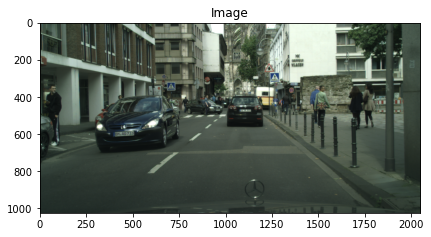

In [7]:
# Display the sample train image
i = 715
train_img = image.img_to_array(image.load_img(f'{train_image_list[i]}'))/255.
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Image')
ax.imshow(train_img)

In [98]:
train_image_list[i]

'../data/leftimg8bit/train/cologne\\cologne_000129_000019_leftImg8bit.png'

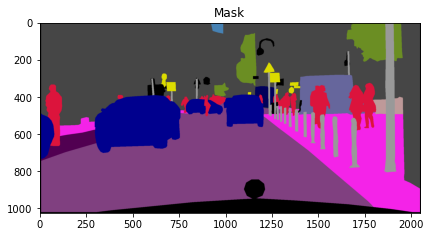

In [8]:
# Display the sample train mask
train_msk = image.img_to_array(image.load_img(f'{train_mask_list[i]}'))/255
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Mask')
ax.imshow(train_msk)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..244.0].


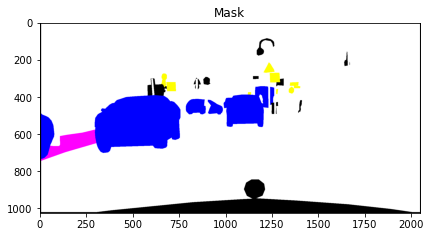

In [9]:
train_msk = image.img_to_array(image.load_img(f'{train_mask_list[i]}'))
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Mask')
ax.imshow(train_msk)

## Model used

https://github.com/VainF/DeepLabV3Plus-Pytorch/blob/master/README.md

In [12]:
# import the necessary module
import subprocess
i = 715
image = f'{train_image_list[i]}'
# Define command to call/run predict.py
command = ['python', 'predict.py',
           '--input', '../data/leftimg8bit/test/munich/munich_000042_000019_leftImg8bit.png',
           '--dataset', 'cityscapes', '--model', 'deeplabv3plus_mobilenet',
           '--ckpt', 'best_deeplabv3plus_mobilenet_cityscapes_os16.pth', '--save_val_results_to', 'test_results']

# run the process
result = subprocess.run(command, capture_output=True, text=True)

# check output for errors
print("Output:\n", result.stdout)
print("Errors:\n", result.stderr)

Output:
 Device: cpu
['../data/leftimg8bit/test/munich/munich_000042_000019_leftImg8bit.png']
Resume model from best_deeplabv3plus_mobilenet_cityscapes_os16.pth
[[8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Errors:
 
100%|██████████| 1/1 [00:08<00:00,  8.32s/it]



In [12]:
import subprocess
def get_mask(path):
    command = ['python', 'predict.py',
           '--input', path,
           '--dataset', 'cityscapes', '--model', 'deeplabv3plus_mobilenet',
           '--ckpt', 'best_deeplabv3plus_mobilenet_cityscapes_os16.pth', '--save_val_results_to', 'test_results']
    # run the process
    mask = subprocess.run(command, capture_output=True, text=True)

    # check output for errors
    print("Output:\n", mask.stdout)
    print("Errors:\n", mask.stderr)    

    return mask

In [24]:
i = 800
image = f'{train_image_list[i]}'
masky = get_mask(image)

Output:
 Device: cpu
['../data/leftimg8bit/train/darmstadt\\darmstadt_000060_000019_leftImg8bit.png']
Resume model from best_deeplabv3plus_mobilenet_cityscapes_os16.pth
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]

Errors:
 
100%|██████████| 1/1 [00:11<00:00, 11.81s/it]



In [82]:
ids = masky.stdout[160:279]
# ids = pd.DataFrame(ids)
print(ids)
len(ids)

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


119

In [11]:
image

'../data/leftimg8bit/train/darmstadt\\darmstadt_000060_000019_leftImg8bit.png'

In [ ]:
# Run the model
# python predict.py --input ../data/sample/berlin/berlin_000000_000019_leftImg8bit.png  --dataset cityscapes --model deeplabv3plus_mobilenet --ckpt best_deeplabv3plus_mobilenet_cityscapes_os16.pth --save_val_results_to test_results

### Visualize the result
#### Print Image and Mask Superimposed

#### USING OPENCV

In [13]:
import cv2
import numpy as np

# Loading our images
# Background/Input image
background = cv2.imread('../data/leftimg8bit/train/cologne/cologne_000129_000019_leftImg8bit.png') 

# mask image
mask_image = cv2.imread('./test_results/cologne_000129_000019_leftImg8bit.png') 

# Resize the mask image to match the background image dimensions
mask_image = cv2.resize(mask_image, (background.shape[1],background.shape[0]))

# Overlay Image
alpha = 0.3
overlay_image = cv2.addWeighted(background, 1 - alpha, mask_image, alpha, 0)


cv2.imshow('Final Overlay', overlay_image)
cv2.imwrite('../data/outputs/bg_image.jpg', overlay_image)
cv2.waitKey(0)

-1

### FastAPI app

https://dev.to/sachingeek/handling-images-on-the-frontend-using-fastapi-3bg2


https://medium.com/@chodvadiyasaurabh/building-an-image-conversion-and-serving-api-with-fastapi-c000b0725e2b


https://github.com/fastapi/fastapi/discussions/6489


https://stackoverflow.com/questions/55873174/how-do-i-return-an-image-in-fastapi


https://stackoverflow.com/questions/55873174/how-do-i-return-an-image-in-fastapi
